**Mutivariate Time Series classification**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
CUDA_LAUNCH_BLOCKING=1.

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
data = pd.read_csv('Heterogeneous_accelerometer_HAR.csv')
data.shape

(3540962, 10)

In [6]:
data.head()

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand


In [7]:
data.dropna(inplace = True)

In [8]:
#Select relevant columns
har = data[['x','y','z','gt']]
har.head()

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand


In [9]:
har['gt'].unique()

array(['stand', 'sit', 'walk', 'stairsup', 'stairsdown', 'bike'],
      dtype=object)

In [10]:
#Extract 500 samples for each class
stand = har[har['gt'] == 'stand']
stand = stand.iloc[0:500,:]

sit = har[har['gt'] == 'sit'].iloc[0:500,:]
walk = har[har['gt'] == 'walk'].iloc[0:500,:]
stairsup = har[har['gt'] == 'stairsup'].iloc[0:500,:]
stairsdown = har[har['gt'] == 'stairsdown'].iloc[0:500,:]
bike = har[har['gt'] == 'bike'].iloc[0:500,:]

In [11]:
harnew = pd.concat([stand, sit, walk, stairsup, stairsdown, bike])

#Replace with integers
harnew['gt'].replace(to_replace = 'stand', value = 0, inplace = True)
harnew['gt'].replace(to_replace = 'sit', value = 1, inplace = True)
harnew['gt'].replace(to_replace = 'walk', value = 2, inplace = True)
harnew['gt'].replace(to_replace = 'stairsup', value = 3, inplace = True)
harnew['gt'].replace(to_replace = 'stairsdown', value = 4, inplace = True)
harnew['gt'].replace(to_replace = 'bike', value = 5, inplace = True)

<ipython-input-11-f9f6903bc690>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  harnew['gt'].replace(to_replace = 'stand', value = 0, inplace = True)
<ipython-input-11-f9f6903bc690>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [12]:
#Function for data prep
def data_preparing(df,  winSize):
    X, y = list(), list()
    for i in range(len(df) - winSize):
        features = df.iloc[:,:-1].values
        target = df.iloc[:,-1].values
        X_i = features[i:i+winSize]
        Y_i = target[i+winSize-1]
        X.append(X_i)
        y.append(Y_i)
    return array(X), array(y)

In [13]:
#Applying the function
n_features = 3 # this is number of channels
winSize = 100 # this is number of timesteps

X, y = data_preparing(harnew, winSize)
print(X.shape, y.shape)

(2900, 100, 3) (2900,)


In [14]:
#Convert to (BatchSize,channels,seqlength)
X = X.reshape(2900,3,100)

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [15]:
#Transform to tensor and use dataloader
# Convert to tensor
train_data = torch.tensor(X_train).float()
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test).float()
test_labels = torch.tensor(y_test).long()


# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Place into dataloader
batchsize    = 32
train_loader = DataLoader(train_data, batch_size = batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [27]:
#Creating model
model = nn.Sequential(nn.Conv1d(in_channels = 3, out_channels = 64, kernel_size = 5, stride = 1),
                      nn.ReLU(),
                      nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 2, stride = 1),
                      nn.ReLU(),
                      nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 1),
                      nn.ReLU(),
                      nn.MaxPool1d(2,2),
                      nn. Flatten(),
                      nn.LazyLinear(128),
                      nn.Linear(128,6)
                      )

In [28]:
epochs = 50

# Loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device) # placing a model on GPU

  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 model.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = model(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 model.eval()

 with torch.no_grad():

    for X,y in test_loader:

            X = X.to(device)
            y = y.to(device)

            ypred =  model(X)
            ypred = ypred.cpu()
            y = y.cpu()


 # Appending test accuracy

 testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
 if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss}')


 epochs : 0  loss : 0.19247004389762878
 epochs : 10  loss : 0.003171273972839117
 epochs : 20  loss : 0.010461105033755302
 epochs : 30  loss : 0.0005825308617204428
 epochs : 40  loss : 9.435466381546576e-06


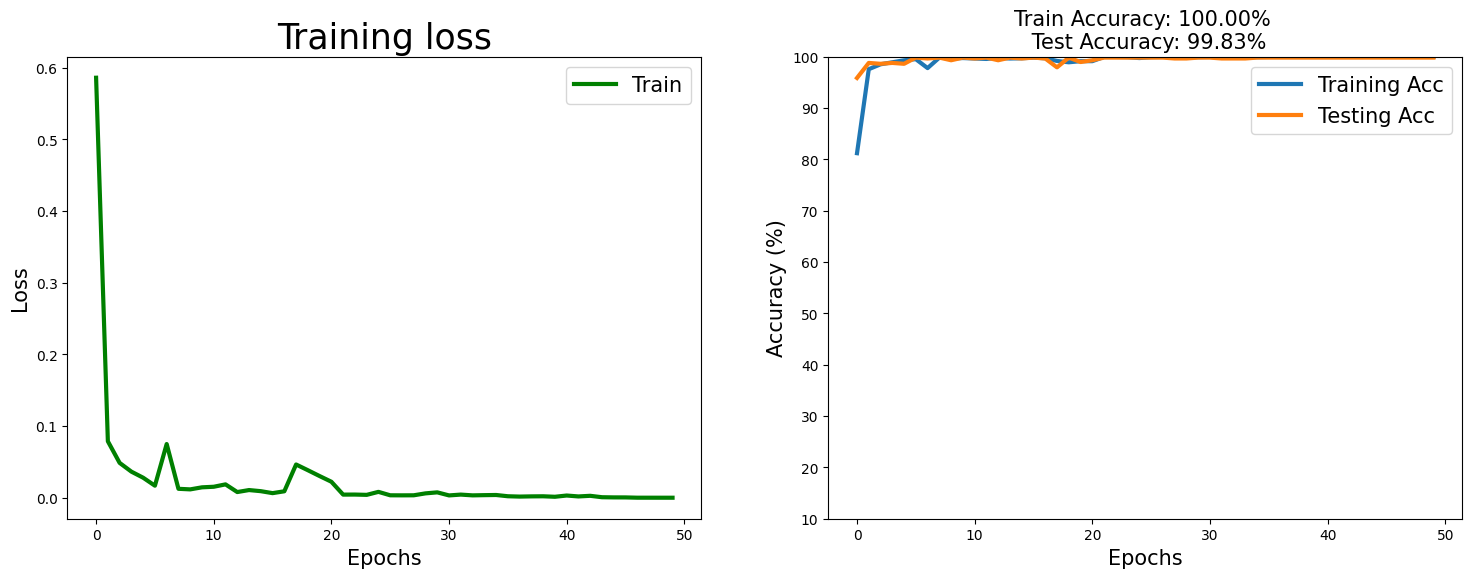

In [29]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()